In [1]:
import os
os.environ["KERAS_HOME"] = os.path.abspath("./.keras_cache")
print("KERAS_HOME =", os.environ["KERAS_HOME"])

KERAS_HOME = D:\Codes\Python\StarDist\.keras_cache


In [2]:
import random, pickle
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from scipy.optimize import curve_fit

from stardist.models import StarDist2D

In [3]:
INPUT_DIR = r"D:/Codes/GitHub/1MD048-RM-for-IA-ML-Project/data/REF_raw_data101_110/REF_raw_data101_110/Pos101/aphase"
IMAGE_EXT = ".tiff"  # ".tif" or ".tiff"

SAVE_DIR = os.path.join(INPUT_DIR, "Masks_STARDIST")
os.makedirs(SAVE_DIR, exist_ok=True)

# time / scale
INTERVAL_MIN = 2
PIXEL_SIZE_UM = 0.0733  # 73.3 nm -> 0.0733 um
PIXEL_AREA = PIXEL_SIZE_UM ** 2

# rolling growth rate
ROLLING_NUMBER = 16  # 16 frames = 32 min (if interval=2 min)

In [4]:
files = sorted([
    os.path.join(INPUT_DIR, f)
    for f in os.listdir(INPUT_DIR)
    if f.lower().endswith(IMAGE_EXT)
])

print("Found images:", len(files))
print("First file:", os.path.basename(files[0]) if files else "None")

Found images: 121
First file: img_000000000.tiff


Found images: 121
First file: img_000000000.tiff
Loaded 121 images.
Example shape: (782, 499)
Showing: img_000000037


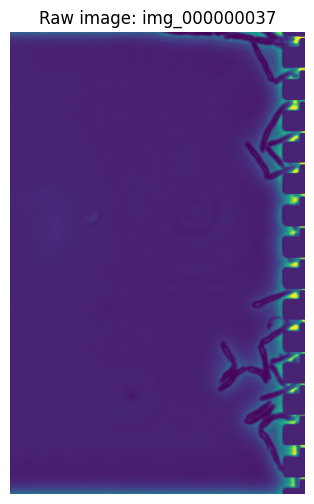

In [5]:
files = sorted([
    os.path.join(INPUT_DIR, f)
    for f in os.listdir(INPUT_DIR)
    if f.lower().endswith(IMAGE_EXT)
])

print("Found images:", len(files))
print("First file:", os.path.basename(files[0]) if files else "None")

artifact_mask = skimage.io.imread("./artifact_mask.png")
artifact_mask = artifact_mask.astype(bool)

orig_imgs = []
imgs = []
for f in files:
    orig_im = skimage.io.imread(f)
    bg = np.median(orig_im)
    im = orig_im.copy()
    im[artifact_mask] = bg
    if im.ndim == 3 and im.shape[0] <= 4 and im.shape[0] < min(im.shape[1], im.shape[2]):
        im = im.transpose(1, 2, 0)
    imgs.append(im)
    orig_imgs.append(orig_im)

print("Loaded", len(imgs), "images.")
print("Example shape:", imgs[0].shape if imgs else None)

# show a random frame
idx = random.randrange(len(imgs))
img0 = imgs[idx]
name0 = os.path.splitext(os.path.basename(files[idx]))[0]
print("Showing:", name0)

plt.figure(figsize=(6, 6))
if img0.ndim == 2:
    plt.imshow(img0)
else:
    plt.imshow(img0[..., 0])
plt.axis("off")
plt.title(f"Raw image: {name0}")
plt.show()

In [30]:
from csbdeep.models.pretrained import get_registered_models
models = get_registered_models(StarDist2D)
print(models)

(('2D_versatile_fluo', '2D_versatile_he', '2D_paper_dsb2018', '2D_demo'), {'2D_versatile_fluo': ('Versatile (fluorescent nuclei)',), '2D_versatile_he': ('Versatile (H&E nuclei)',), '2D_paper_dsb2018': ('DSB 2018 (from StarDist 2D paper)',), '2D_demo': ()})


In [34]:
model = StarDist2D.from_pretrained("2D_versatile_fluo")

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [35]:
def norm01(x):
    x = x.astype(np.float32)
    lo, hi = np.percentile(x, (1, 99))
    x = (x - lo) / (hi - lo + 1e-8)
    return np.clip(x, 0, 1)

Instances (StarDist): 40


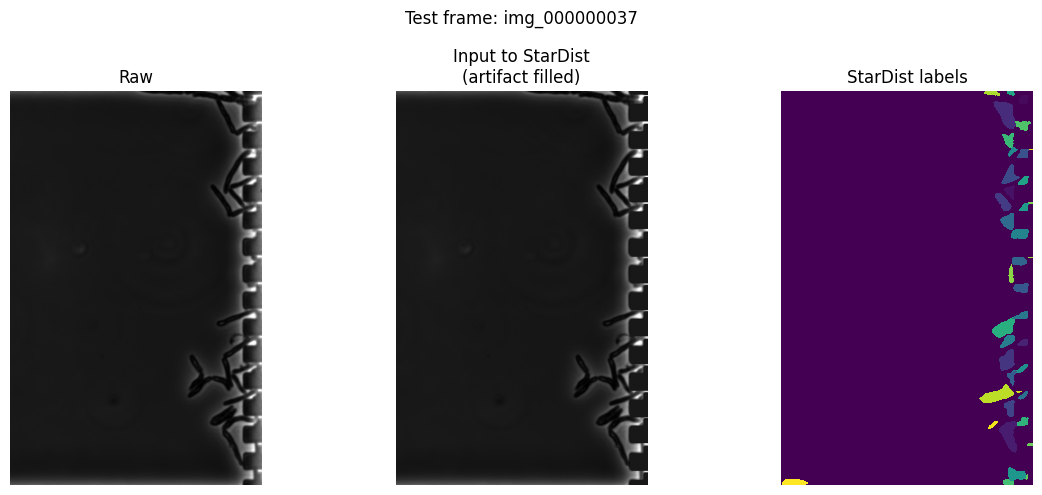

In [36]:
test_img = imgs[idx]
x = norm01(test_img)

labels, details = model.predict_instances(x)
labels = labels.astype(np.uint16)

# 再保险：预测后也把 artifact 区域清零（避免残留影响面积）
labels[artifact_mask] = 0

print("Instances (StarDist):", int(labels.max()))

plt.figure(figsize=(12, 5), facecolor="white")

plt.subplot(1, 3, 1)
plt.imshow(orig_imgs[idx], cmap="gray")
plt.axis("off")
plt.title("Raw")

plt.subplot(1, 3, 2)
plt.imshow(test_img, cmap="gray")
plt.axis("off")
plt.title("Input to StarDist\n(artifact filled)")

plt.subplot(1, 3, 3)
plt.imshow(labels, interpolation="nearest")
plt.axis("off")
plt.title("StarDist labels")

plt.suptitle(f"Test frame: {name0}")
plt.tight_layout()
plt.show()

In [11]:
pos_areas_pixels = np.zeros(len(imgs), dtype=float)

for i, (img, path) in enumerate(zip(imgs, files)):
    base = os.path.splitext(os.path.basename(path))[0]
    print(f"[{i + 1}/{len(imgs)}] StarDist segmenting {base}")

    x = norm01(img)
    labels, details = model.predict_instances(x)
    labels = labels.astype(np.uint16)
    labels[artifact_mask] = 0

    # total area = sum of pixel counts of all non-zero labels
    counts = np.unique(labels, return_counts=True)[1][1:]
    pos_areas_pixels[i] = counts.sum()

    out_mask = os.path.join(SAVE_DIR, f"MASK_{base}.tif")
    skimage.io.imsave(out_mask, labels, check_contrast=False)

# save areas
with open(os.path.join(SAVE_DIR, "growth_areas.pickle"), "wb") as f:
    pickle.dump(pos_areas_pixels, f)

print("Saved masks to:", SAVE_DIR)
print("Saved growth_areas.pickle:", os.path.join(SAVE_DIR, "growth_areas.pickle"))
print("Area sample (pixels):", pos_areas_pixels[:10])

[1/121] StarDist segmenting img_000000000
[2/121] StarDist segmenting img_000000001
[3/121] StarDist segmenting img_000000002
[4/121] StarDist segmenting img_000000003
[5/121] StarDist segmenting img_000000004
[6/121] StarDist segmenting img_000000005
[7/121] StarDist segmenting img_000000006
[8/121] StarDist segmenting img_000000007
[9/121] StarDist segmenting img_000000008
[10/121] StarDist segmenting img_000000009
[11/121] StarDist segmenting img_000000010
[12/121] StarDist segmenting img_000000011
[13/121] StarDist segmenting img_000000012
[14/121] StarDist segmenting img_000000013
[15/121] StarDist segmenting img_000000014
[16/121] StarDist segmenting img_000000015
[17/121] StarDist segmenting img_000000016
[18/121] StarDist segmenting img_000000017
[19/121] StarDist segmenting img_000000018
[20/121] StarDist segmenting img_000000019
[21/121] StarDist segmenting img_000000020
[22/121] StarDist segmenting img_000000021
[23/121] StarDist segmenting img_000000022
[24/121] StarDist se

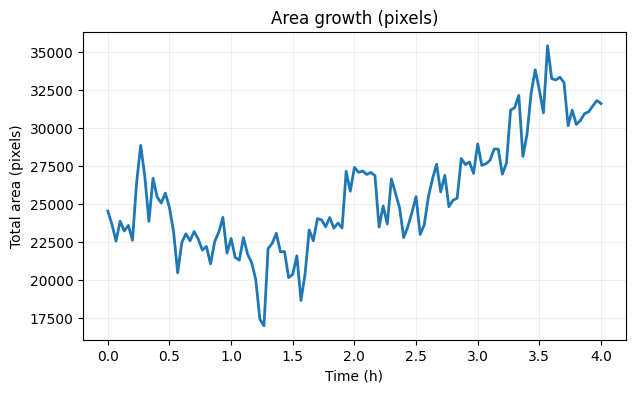

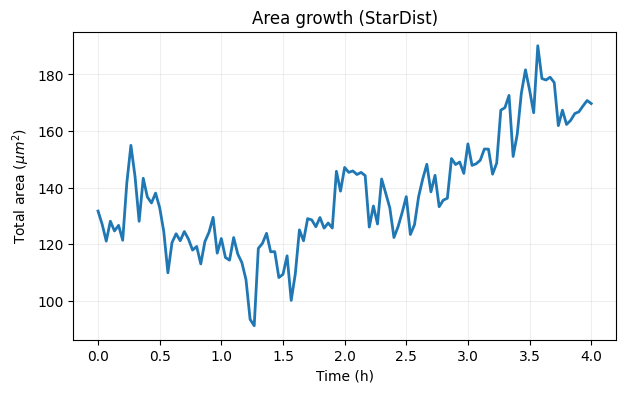

Saved: D:/Codes/GitHub/1MD048-RM-for-IA-ML-Project/data/REF_raw_data101_110/REF_raw_data101_110/Pos101/aphase\Masks_STARDIST\Area_growth_stardist.svg


In [12]:
time_h = np.arange(len(pos_areas_pixels)) * (INTERVAL_MIN / 60.0)
pos_areas_um2 = pos_areas_pixels * PIXEL_AREA

plt.figure(figsize=(7, 4), facecolor="white")
plt.plot(time_h, pos_areas_pixels, lw=2)
plt.xlabel("Time (h)")
plt.ylabel("Total area (pixels)")
plt.title("Area growth (pixels)")
plt.grid(alpha=0.2)
plt.show()

plt.figure(figsize=(7, 4), facecolor="white")
plt.plot(time_h, pos_areas_um2, lw=2)
plt.xlabel("Time (h)")
plt.ylabel(r"Total area ($\mu m^2$)")
plt.title("Area growth (StarDist)")
plt.grid(alpha=0.2)
plt.savefig(os.path.join(SAVE_DIR, "Area_growth_stardist.svg"), bbox_inches="tight")
plt.show()

print("Saved:", os.path.join(SAVE_DIR, "Area_growth_stardist.svg"))

Growth rate length: 105
Fits ok: 105 / 105
Example growth rates: [ 0.19701441  0.14136095 -0.00206345 -0.11463721 -0.17515648 -0.26598293
 -0.33164745 -0.4452626  -0.46225278 -0.37296555]


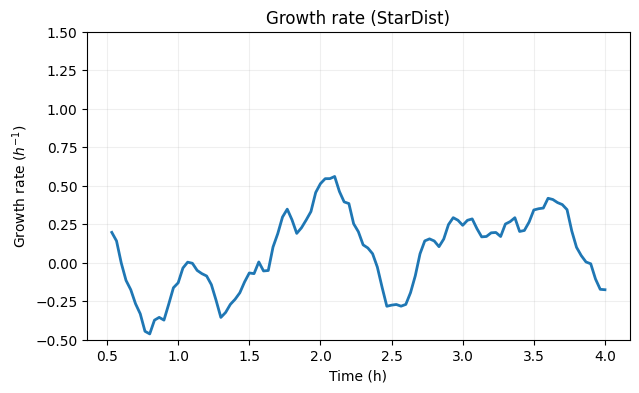

Saved: D:/Codes/GitHub/1MD048-RM-for-IA-ML-Project/data/REF_raw_data101_110/REF_raw_data101_110/Pos101/aphase\Masks_STARDIST\growth_rate_rolling.pickle
Saved: D:/Codes/GitHub/1MD048-RM-for-IA-ML-Project/data/REF_raw_data101_110/REF_raw_data101_110/Pos101/aphase\Masks_STARDIST\Growth_rate_stardist.svg


In [13]:
def exp_growth_fit(x, a, b):
    return a * np.exp(b * x)


areas = pos_areas_um2.copy()
growth_rates = []

fit_ok = 0
for i in range(ROLLING_NUMBER, len(areas)):
    xw = np.arange(ROLLING_NUMBER)
    yw = areas[i - ROLLING_NUMBER:i]

    if np.any(yw <= 0):
        growth_rates.append(np.nan)
        continue

    p0 = [yw[0], 0.001]
    try:
        popt, _ = curve_fit(exp_growth_fit, xw, yw, p0=p0, maxfev=5000)
        b_per_frame = popt[1]
        b_per_hour = b_per_frame * (60.0 / INTERVAL_MIN)
        growth_rates.append(b_per_hour)
        fit_ok += 1
    except RuntimeError:
        growth_rates.append(np.nan)

growth_rates = np.array(growth_rates, dtype=float)

time_gr_h = np.arange(ROLLING_NUMBER, len(areas)) * (INTERVAL_MIN / 60.0)

with open(os.path.join(SAVE_DIR, "growth_rate_rolling.pickle"), "wb") as f:
    pickle.dump(growth_rates, f)

print("Growth rate length:", len(growth_rates))
print("Fits ok:", fit_ok, "/", len(growth_rates))
valid = growth_rates[~np.isnan(growth_rates)]
print("Example growth rates:", valid[:10] if len(valid) else "None")

plt.figure(figsize=(7, 4), facecolor="white")
plt.plot(time_gr_h, growth_rates, lw=2)
plt.xlabel("Time (h)")
plt.ylabel(r"Growth rate ($h^{-1}$)")
plt.title("Growth rate (StarDist)")
plt.ylim(-0.5, 1.5)
plt.grid(alpha=0.2)
plt.savefig(os.path.join(SAVE_DIR, "Growth_rate_stardist.svg"), bbox_inches="tight")
plt.show()

print("Saved:", os.path.join(SAVE_DIR, "growth_rate_rolling.pickle"))
print("Saved:", os.path.join(SAVE_DIR, "Growth_rate_stardist.svg"))

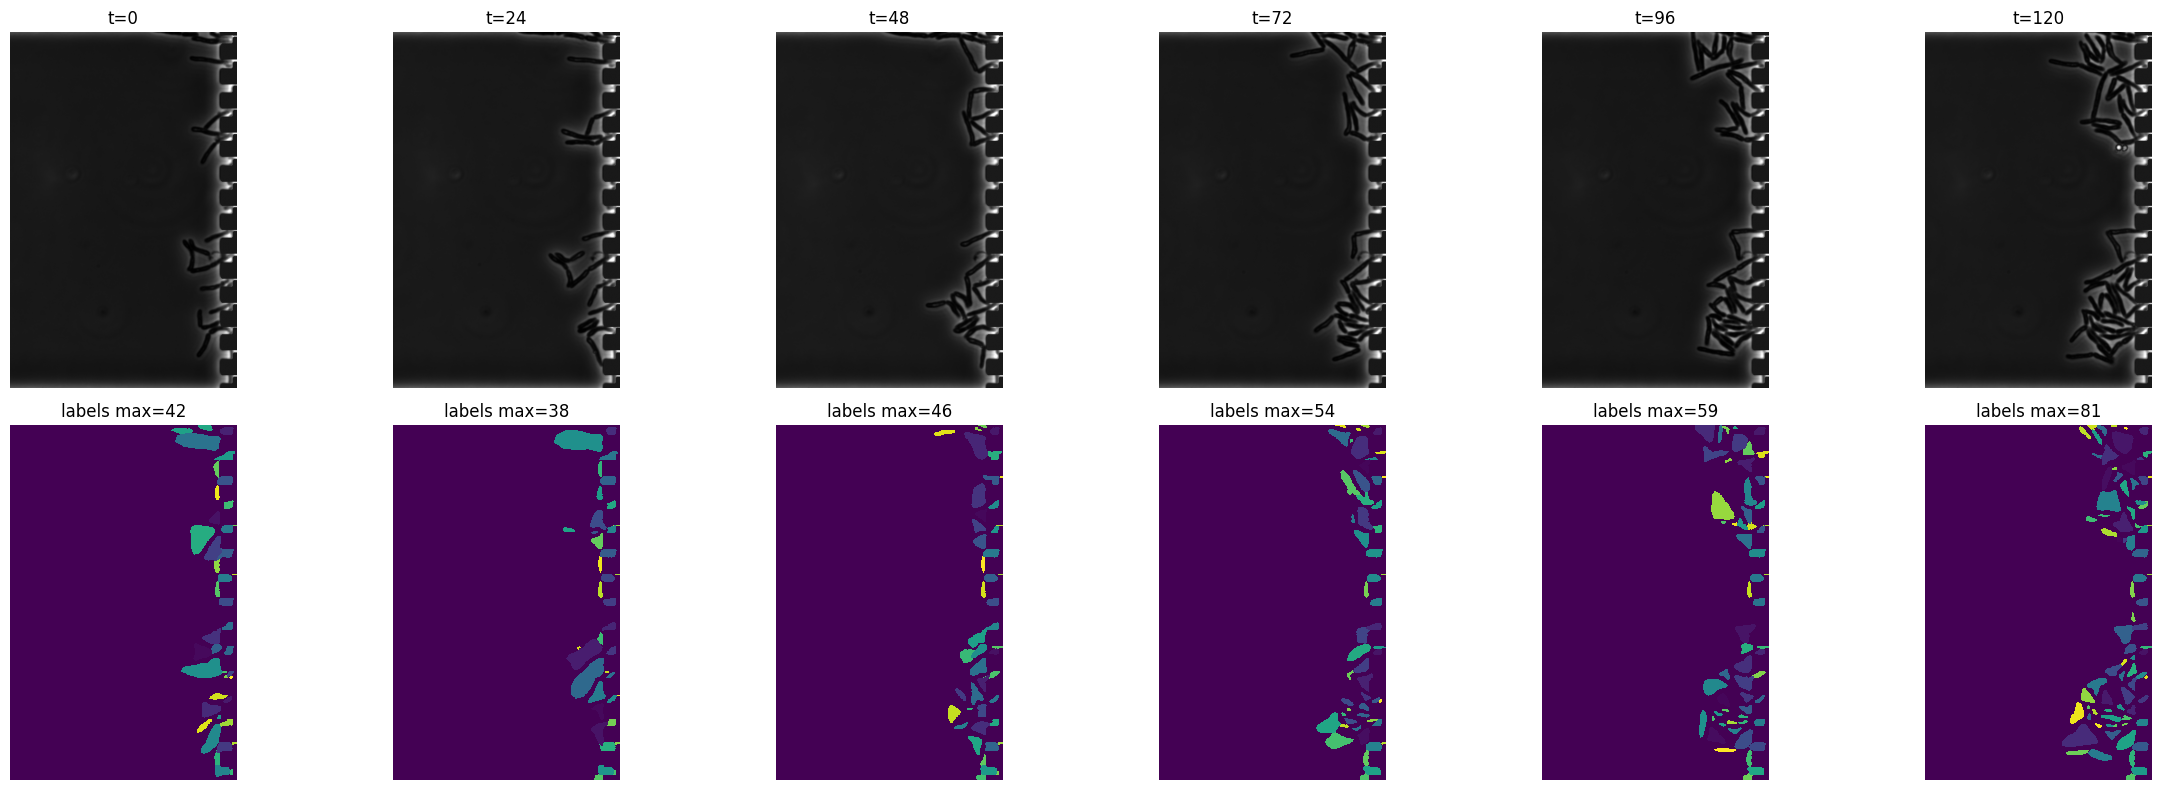

In [14]:
n_show = 6
idxs = np.linspace(0, len(imgs) - 1, n_show).astype(int)

plt.figure(figsize=(24, 8), facecolor="white")

for k, i in enumerate(idxs):
    base = os.path.splitext(os.path.basename(files[i]))[0]
    mask_path = os.path.join(SAVE_DIR, f"MASK_{base}.tif")
    m = skimage.io.imread(mask_path)

    plt.subplot(2, n_show, k + 1)
    plt.imshow(imgs[i], cmap="gray")
    plt.axis("off")
    plt.title(f"t={i}")

    plt.subplot(2, n_show, n_show + k + 1)
    plt.imshow(m, interpolation="nearest")
    plt.axis("off")
    plt.title(f"labels max={m.max()}")

plt.tight_layout()
plt.show()